# Introduction
Ce projet a été mené par Valentin Smague et Clément Gadeau dans le cadre d'un cours de deuxième année de l'ENSAE Paris : Python pour la DataScience.
Nous avons choisi pour projet de programmer un modèle qui saurait reconnaître le genre d'un morceau musical. La tâche étant complexe, nous nous sommes retreints aux données rendues disponibles par l'API Spotify, qui nous permettent de nous affranchir de la difficile tâche d'analyse de l'audio.

Peut-on à partir de données quantitatives sur un morceau, prédire le genre musical auquel il appartient ?

Voilà tout l'enjeu de notre projet dont voici une ébauche :

#### __I. Récupérer et traiter les données__
  - Requêter l'API Spotify
  - Re-traiter la variable de genre
  - Constituer une base de donnée qui retranscrit bien l'étendu de l'univers musical

#### __II. Visualiser pour comprendre les données__
  - Vérifier la bonne répartition des poids dans notre base
  - Comprendre les relations entre les variables
  - Comprendre les relations entre les variables et le genre

#### __III. Modéliser la prédiction du genre__
  - Random Forest
  - Valentiiiiin c:

---

# __I. Récupérer et traiter les données__

Nous aurons avant tout besoin d'importer quelques modules et packages

In [1]:
import requests
import pandas as pd
from base64 import b64encode
import ast

import matplotlib.pyplot as plt

import numpy as np # Pour la normalisation et calculs de moyenne
import matplotlib.pyplot as plt # Pour la visualisation
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV # Split de dataset et optimisation des hyperparamètres
from sklearn.ensemble import RandomForestClassifier # Random forest

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report # Métriques pour la mesure de performances
from sklearn.preprocessing import normalize, StandardScaler
from pprint import pprint

from sklearn.ensemble import GradientBoostingClassifier # XGBoost

from xgboost import XGBClassifier


### __Requêter l'API__

Pour constituer notre base de données, nous utilisons l'API Spotify. Le premier problème auquel nous sommes confrontés est que Spotify ne met pas à disposition une quelconque base de donnée déjà constituée ; pas même une liste de morceaux. 
Cependant nous pouvons requêter l'API pour obtenir des informations sur : un morceau donné, un artiste donné, ou une playlist donnée. C'est ce que nous avons choisi de faire. 

Nous sélectionnons donc une playlist de 10 000 morceaux déjà faite par un utilisateur Spotify, afin d'obtenir des informations sur chaque morceau qui la compose : titre, id, artist, artist id. 
Ensuite, nous récupérons les informations qui nous intéressent sur chaque morceaux : les track features, qui sont un tas d'indices quantitatifs sur chaque morceau.
Enfin, nous récupérons le genre qui n'est associé qu'à l'artiste, et pas au morceau.

D'abord, nous devons obtenir le token d'accès à l'API. Les logins sont dans logins.txt


In [2]:
def get_access_token():
    """
    Returns the access token for Spotify API
    """
    '''logins = "Data/data/logins.txt"
    with open(logins, "r") as file:
        client_id = str(file.readline().strip())
        client_secret = str(file.readline())
    file.close()'''
    client_id = "b6871ef2f14a4b60888a32454862b876"
    client_secret = "3a5d22aa09434e32a9760159ca3bb234"
    
    token_url = "https://accounts.spotify.com/api/token"

    # Concatenates client-id and client_secret, then encodes them in base64
    credentials = b64encode(f"{client_id}:{client_secret}".encode()).decode('utf-8')

    # Requests headers
    headers = {'Authorization': f'Basic {credentials}','Content-Type': 'application/x-www-form-urlencoded',}

    # Requests body
    data = {'grant_type': 'client_credentials',}

    # Does the Request
    response = requests.post(token_url, headers=headers, data=data)

    # Makes sure the response does not mean error.
    if response.status_code == 200:
        # We obtain the access token
        access_token = response.json().get('access_token')
        return(access_token)
    else:
        print(f"Error during the token request : {response.status_code} - {response.text}")
        return(None)


access_token = get_access_token()

### __Constituer un premier dataset__

Ensuite nous utilisons ce token pour notre première requête : obtenir des informations sur une playlist de 10 000 morceaux. Nous avons choisi ce genre de playlist faite pour pouvoir être utilisée dans l'API, et nous espérons donc qu'elle fasse état d'une bonne répartition des genres.

Nous entrons l'id de la playlist en question.
Nous récupérons les informations de la playlist relatives aux morceaux dans get_all_playlist_tracks.
Avec les informations obtenues précédemment, nous créons avec get_track_id_and_artist un dataframe qui pour chaque morceau de la playlist en donne le titre, l'id, l'artist, l'artist id.

In [3]:
playlist_id = '04ZwFco4KsjgPlVMtzwfgS'

def get_all_playlist_tracks(playlist_id, access_token):
    playlist_url = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    headers = {'Authorization': 'Bearer ' + access_token}
    params = {'offset': 0, 'limit': 100}  # Limits the response to 100 each time.

    all_tracks = []

    while True:
        response = requests.get(playlist_url, headers=headers, params=params)

        if response.status_code == 200:
            playlist_data = response.json()
            tracks = playlist_data['items']
            all_tracks.extend(tracks)

            # Check if there are other tracks to recover
            if playlist_data['next']:
                # Update the offset to get the following page.
                params['offset'] += params['limit']
            else:
                break
        else:
            print(f"Error retrieving tracks from playlist. Error code : {response.status_code}")
            return None

    return all_tracks


def get_track_id_and_artist(tracks):
    if tracks:
        title = []
        track_id = []
        artist = []
        artist_id = []
        for track in tracks:
            title.append(track['track']['name'])
            track_id.append(track['track']['id'])
            artist.append(track['track']['artists'][0]['name'])
            artist_id.append(track['track']['artists'][0]['id'])
        df = pd.DataFrame({'Title':title})
        df['track_id'] = track_id
        df['artist'] = artist
        df['artist_id'] = artist_id
        return df
    else:
        print("No track found.")
        return None

all_tracks = get_all_playlist_tracks(playlist_id, access_token)
df_init = get_track_id_and_artist(all_tracks)

Voilà ce à quoi ressemble ce premier dataframe :

In [4]:
df_init.head()

,Title,track_id,artist,artist_id
0,Act Naturally,3JWEMzwpcWCvu4Qw1BIbYi,Buck Owens,2FMZn5P3WATd7Il6FgPJNu
1,How Ya Do Dat,1KLhUURHRl72xGO5A94lme,Young Bleed,5GQgxUq4MOuXXV99WrRuev
2,Bury Me Alive,5SbJacDwoaouWkGxG1TrHq,We Are The Fallen,4V0jSDdGGQ2VhYuSOjBUjI
3,Army of Me,3vEmpJQC2p8h0U3OiBufQm,Björk,7w29UYBi0qsHi5RTcv3lmA
4,Dynamite,1DqdF42leyFIzqNDv9CjId,Taio Cruz,6MF9fzBmfXghAz953czmBC


Puis nous voulons pour chacun de ces morceaux des informations quantitatives. Pour cela nous utilisons get_track_features. On fait une seule et même requête pour 100 morceaux à la fois (c'est le maximum imposé par l'API).

In [5]:
def get_track_features(track_id, headers):
    """
    Returns a dictionnary for the track features.
    track_id my be a list of under 100 tracks or just a string for one single track.
    """
    
    str_track_id = ','.join(track_id)

    params = {'ids': str_track_id}
    features_url = "https://api.spotify.com/v1/audio-features"
    response = requests.get(features_url, headers=headers,params=params)
    #print(response)

    # Verify the response: 
    if response.status_code == 200:
        # La réponse est au format JSON, imprimez toutes les caractéristiques
        data = response.json()
        return(data['audio_features'])
    else:
        print(f"Erreur lors de la requête : {response.status_code} - {response.text}")
        return([None]*len(track_id))

On utilise la fonction pour obtenir les caractéristiques de tous les morceaux de notre dataset initial en opérant 100 par 100.

In [6]:
track_list = df_init['track_id'].tolist()
track_number = len(track_list)
print("There are ", track_number, " tracks")

nb_use_token_track = track_number // 100 + int(track_number % 100 != 0)
track_features_list = []

headers = {'Authorization': f'Bearer {access_token}',}
for k in range(nb_use_token_track-1):
    track_features_list = track_features_list + get_track_features(track_list[100*k:100*(k+1)],headers)
track_features_list = track_features_list + get_track_features(track_list[(nb_use_token_track-1)*100:],headers)

df_init['track_features'] = track_features_list

df_init.head()

There are  9999  tracks


,Title,track_id,artist,artist_id,track_features
0,Act Naturally,3JWEMzwpcWCvu4Qw1BIbYi,Buck Owens,2FMZn5P3WATd7Il6FgPJNu,"{'danceability': 0.552, 'energy': 0.474, 'key'..."
1,How Ya Do Dat,1KLhUURHRl72xGO5A94lme,Young Bleed,5GQgxUq4MOuXXV99WrRuev,"{'danceability': 0.788, 'energy': 0.451, 'key'..."
2,Bury Me Alive,5SbJacDwoaouWkGxG1TrHq,We Are The Fallen,4V0jSDdGGQ2VhYuSOjBUjI,"{'danceability': 0.529, 'energy': 0.882, 'key'..."
3,Army of Me,3vEmpJQC2p8h0U3OiBufQm,Björk,7w29UYBi0qsHi5RTcv3lmA,"{'danceability': 0.462, 'energy': 0.677, 'key'..."
4,Dynamite,1DqdF42leyFIzqNDv9CjId,Taio Cruz,6MF9fzBmfXghAz953czmBC,"{'danceability': 0.754, 'energy': 0.804, 'key'..."


Seulement, maintenant on a une colonne features qui contient elle même plusieurs colonnes. C'est pourquoi on l'extrait.

In [7]:
from Script.functions import get_features_labels
Features = get_features_labels(headers)
# We get a list of the features labels.

for feature in Features:
    df_init[feature] = df_init['track_features'].apply(lambda x: x.get(feature))
df_init.drop(columns=['track_features'], inplace = True)

df_init.head()

,Title,track_id,artist,artist_id,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Act Naturally,3JWEMzwpcWCvu4Qw1BIbYi,Buck Owens,2FMZn5P3WATd7Il6FgPJNu,0.552,0.474,7,-6.847,1,0.0275,...,0.1730,0.700,92.156,audio_features,3JWEMzwpcWCvu4Qw1BIbYi,spotify:track:3JWEMzwpcWCvu4Qw1BIbYi,https://api.spotify.com/v1/tracks/3JWEMzwpcWCv...,https://api.spotify.com/v1/audio-analysis/3JWE...,143693,4
1,How Ya Do Dat,1KLhUURHRl72xGO5A94lme,Young Bleed,5GQgxUq4MOuXXV99WrRuev,0.788,0.451,1,-9.313,1,0.3180,...,0.1340,0.302,89.970,audio_features,1KLhUURHRl72xGO5A94lme,spotify:track:1KLhUURHRl72xGO5A94lme,https://api.spotify.com/v1/tracks/1KLhUURHRl72...,https://api.spotify.com/v1/audio-analysis/1KLh...,271067,4
2,Bury Me Alive,5SbJacDwoaouWkGxG1TrHq,We Are The Fallen,4V0jSDdGGQ2VhYuSOjBUjI,0.529,0.882,11,-2.962,0,0.0444,...,0.3590,0.179,119.974,audio_features,5SbJacDwoaouWkGxG1TrHq,spotify:track:5SbJacDwoaouWkGxG1TrHq,https://api.spotify.com/v1/tracks/5SbJacDwoaou...,https://api.spotify.com/v1/audio-analysis/5SbJ...,286640,4
3,Army of Me,3vEmpJQC2p8h0U3OiBufQm,Björk,7w29UYBi0qsHi5RTcv3lmA,0.462,0.677,6,-9.262,1,0.0327,...,0.2260,0.468,172.192,audio_features,3vEmpJQC2p8h0U3OiBufQm,spotify:track:3vEmpJQC2p8h0U3OiBufQm,https://api.spotify.com/v1/tracks/3vEmpJQC2p8h...,https://api.spotify.com/v1/audio-analysis/3vEm...,234333,4
4,Dynamite,1DqdF42leyFIzqNDv9CjId,Taio Cruz,6MF9fzBmfXghAz953czmBC,0.754,0.804,4,-3.177,1,0.0853,...,0.0329,0.818,119.968,audio_features,1DqdF42leyFIzqNDv9CjId,spotify:track:1DqdF42leyFIzqNDv9CjId,https://api.spotify.com/v1/tracks/1DqdF42leyFI...,https://api.spotify.com/v1/audio-analysis/1Dqd...,203867,4


Enfin, nous voulons accéder au genre de chaque morceau. L'API associe le genre d'un morceau à son artiste. En outre, l'API n'associe pas un unique genre à un morceau, mais une liste de genres. De la même façon que pour obtenir les features, on émet une requête pour obtenir le genre de l'artiste.

In [8]:
def get_artists_genres(artist_ids, headers):
    # Convert the list of artist IDs to a comma-separated string
    artists_str = ",".join(artist_ids)

    # Endpoint to obtain information on several artists
    endpoint = f"https://api.spotify.com/v1/artists?ids={artists_str}"

    # Make a GET request to the Spotify API
    response = requests.get(endpoint, headers=headers)

    # Check if request was successful (status 200 OK)
    if response.status_code == 200:
        # Analyze the JSON response
        data = response.json()

        # Recover each artist's genre
        all_genres = []
        for artist_data in data["artists"]:
            genres = artist_data.get("genres", [])
            all_genres.append(genres)

        return all_genres
    else:
        # Display error message if query failed
        print(f"Error {response.status_code}: Unable to obtain artist genres.")
        return [None]*len(artist_ids)

In [9]:
artist_list = df_init['artist_id'].tolist()
nb_artist = len(artist_list)
print("There are ", nb_artist, " artists")

nb_use_token_artist = nb_artist // 50 + int(nb_artist % 50 != 0)
artist_genres_list = []

for k in range(nb_use_token_artist-1):
    artist_genres_list = artist_genres_list + get_artists_genres(artist_list[50*k:50*(k+1)], headers)
    #print(k/nb_use_token_artist)
artist_genres_list = artist_genres_list + get_artists_genres(artist_list[(nb_use_token_artist-1)*50:], headers)
df_init['genres'] = artist_genres_list

df_init.head()

There are  9999  artists


,Title,track_id,artist,artist_id,danceability,energy,key,loudness,mode,speechiness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genres
0,Act Naturally,3JWEMzwpcWCvu4Qw1BIbYi,Buck Owens,2FMZn5P3WATd7Il6FgPJNu,0.552,0.474,7,-6.847,1,0.0275,...,0.700,92.156,audio_features,3JWEMzwpcWCvu4Qw1BIbYi,spotify:track:3JWEMzwpcWCvu4Qw1BIbYi,https://api.spotify.com/v1/tracks/3JWEMzwpcWCv...,https://api.spotify.com/v1/audio-analysis/3JWE...,143693,4,"[bakersfield sound, classic country pop, count..."
1,How Ya Do Dat,1KLhUURHRl72xGO5A94lme,Young Bleed,5GQgxUq4MOuXXV99WrRuev,0.788,0.451,1,-9.313,1,0.3180,...,0.302,89.970,audio_features,1KLhUURHRl72xGO5A94lme,spotify:track:1KLhUURHRl72xGO5A94lme,https://api.spotify.com/v1/tracks/1KLhUURHRl72...,https://api.spotify.com/v1/audio-analysis/1KLh...,271067,4,"[baton rouge rap, dirty south rap]"
2,Bury Me Alive,5SbJacDwoaouWkGxG1TrHq,We Are The Fallen,4V0jSDdGGQ2VhYuSOjBUjI,0.529,0.882,11,-2.962,0,0.0444,...,0.179,119.974,audio_features,5SbJacDwoaouWkGxG1TrHq,spotify:track:5SbJacDwoaouWkGxG1TrHq,https://api.spotify.com/v1/tracks/5SbJacDwoaou...,https://api.spotify.com/v1/audio-analysis/5SbJ...,286640,4,[pixie]
3,Army of Me,3vEmpJQC2p8h0U3OiBufQm,Björk,7w29UYBi0qsHi5RTcv3lmA,0.462,0.677,6,-9.262,1,0.0327,...,0.468,172.192,audio_features,3vEmpJQC2p8h0U3OiBufQm,spotify:track:3vEmpJQC2p8h0U3OiBufQm,https://api.spotify.com/v1/tracks/3vEmpJQC2p8h...,https://api.spotify.com/v1/audio-analysis/3vEm...,234333,4,"[art pop, electronica, experimental pop, exper..."
4,Dynamite,1DqdF42leyFIzqNDv9CjId,Taio Cruz,6MF9fzBmfXghAz953czmBC,0.754,0.804,4,-3.177,1,0.0853,...,0.818,119.968,audio_features,1DqdF42leyFIzqNDv9CjId,spotify:track:1DqdF42leyFIzqNDv9CjId,https://api.spotify.com/v1/tracks/1DqdF42leyFI...,https://api.spotify.com/v1/audio-analysis/1Dqd...,203867,4,"[dance pop, pop, pop rap]"


In [ ]:
#path = '/home/onyxia/work/Python-pour-la-Data-Science/Data/data/Titles2.csv'
#df_init.to_csv(path, index=False)

On nettoie alors notre base de données pour enlever tous les éléments sans genre. 

In [10]:
df_cleaned = df_init.copy()
print("Tracks number before cleaning ", df_cleaned.shape[0])
df_cleaned = df_cleaned.dropna(subset=['genres'])
df_cleaned = df_cleaned[df_cleaned['genres'].apply(lambda x: isinstance(x, list) and any(isinstance(item, str) and any(c.isalpha() for c in item) for item in x))]
#df_cleaned = df_cleaned[df_cleaned['genres'].apply(lambda x: (isinstance(x, str) and any(c.isalpha() for c in x)))]
#If the data_frame is read from a csv file.
print("Tracks number after cleaning ", df_cleaned.shape[0])
print(f"Thus there were {9999 - df_cleaned.shape[0]} tracks without genre")

df_cleaned = df_cleaned.drop(columns=['Title', 'track_id', 'artist', 'artist_id', 'type', 'id', 'uri', 'track_href', 'analysis_url'])
df_cleaned.head()


Tracks number before cleaning  9999
Tracks number after cleaning  9352
Thus there were 647 tracks without genre


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genres
0,0.552,0.474,7,-6.847,1,0.0275,0.33600,0.000000,0.1730,0.700,92.156,143693,4,"[bakersfield sound, classic country pop, count..."
1,0.788,0.451,1,-9.313,1,0.3180,0.11800,0.000000,0.1340,0.302,89.970,271067,4,"[baton rouge rap, dirty south rap]"
2,0.529,0.882,11,-2.962,0,0.0444,0.02080,0.000013,0.3590,0.179,119.974,286640,4,[pixie]
3,0.462,0.677,6,-9.262,1,0.0327,0.00786,0.000072,0.2260,0.468,172.192,234333,4,"[art pop, electronica, experimental pop, exper..."
4,0.754,0.804,4,-3.177,1,0.0853,0.00332,0.000000,0.0329,0.818,119.968,203867,4,"[dance pop, pop, pop rap]"


### __Nettoyer le dataset : identifier un genre unique pour chaque morceau__

Le problème est maintenant que l'on a une liste de genre pour chaque morceau, et pas un unique genre par morceau. Plutôt que de tronquer la liste à son premier élément, nous préférons pour chaque liste vérifier s'il n'y a pas de sous-genres dans la liste. 

Un sous genre sera défini comme un genre qui contient un autre genre dans son nom. Par exemple, nous considérerons le hardrock comme un sous genre du rock. Par contre le pop-rock sera considéré simultanément comme un sous genre du rock et de la pop. On veut donc un dictionnaire qui à chaque genre associe une liste de ses genres parents.

On crée 3 fonctions
- get_genre_list qui prend en argument un dataset, et qui renvoie la liste des genres musicaux dans le dataset.
- reduce_genres_list qui prend en argument une liste des genres musicaux, et qui renvoie un dictionnaire qui associe à chaque sous-genre ses genres parents.
- remake_genre_list qui prend en argument une liste de genres musicaux, et qui renvoie le grand genre le plus fréquent dans les grands genres associés aux éléments de la liste de genres.

In [11]:
def get_genres_list(data_set):
    """Returns the list of genres that appear in data_set"""
    union_genres = set()
    for genre_str in data_set['genres']:
        #if pd.notna(genre_str):
            # We use ast.literal_eval to get a list from a string of a list
        genre_list = genre_str #ast.literal_eval(genre_str)
        union_genres = union_genres.union(set(genre_list))
    return(list(union_genres))


def reduce_genres_list(list_of_genres):
    """Returns a dictionnary of genres parenthood for a list of genre"""
    sorted_list = sorted(list_of_genres, key=lambda x: len(x))
    visited_words = []
    dict = {}
    for genre in sorted_list:
        dict[genre] = [genre]
        for word in visited_words:
            if word in genre and word != genre:
                dict[genre] += [word]
        if len(dict[genre]) > 1:
            dict[genre].remove(genre)
        visited_words += [genre]
    return dict


def remake_genre_list(genre_list, dict):
    """
    Returns the most frequent genre from a list of genre.
    It will be used for each tracks' list of genres.
    """
    new_list = []
    for genre in genre_list: #ast.literal_eval(genre_list):
        new_list += dict[genre]
    most_frequent_genre = max(set(new_list), key=new_list.count)
    return most_frequent_genre

On crée une liste des genres présents. Puis on l'utilise pour obtenir le dictionnaire des parentées de genres. Ensuite on transforme la colonne des genres pour que chaque élément soit le grand genre le plus parlant pour chaque morceau.

On affiche ensuite un data frame qui montre pour chaque grand genre final le nombre d'occurrence qu'il a dans la base de donnée ainsi modifiée. On observe que certains genres sont très représentés mais qu'assez vite on arrive sur des genres peu fréquents.

In [12]:
df_cleaned_copy = df_cleaned.copy()
dict = reduce_genres_list(get_genres_list(df_cleaned_copy))
df_cleaned_copy['genres'] = df_cleaned_copy.apply(lambda row: remake_genre_list(row['genres'], dict), axis=1)
genres_occurrence = df_cleaned_copy['genres'].value_counts().reset_index()
genres_occurrence.head()

,genres,count
0,pop,2411
1,rock,909
2,metal,607
3,hip hop,416
4,rap,367


In [13]:
saved_genres = genres_occurrence.iloc[:12, 0].tolist()
df_filtered = df_cleaned_copy[df_cleaned_copy['genres'].isin(saved_genres)]
print(f"There are {df_filtered.shape[0]} tracks associated to one of the top 12 most listened genres")


There are 6447 tracks associated to one of the top 12 most listened genres


### __Interroger nos résultats dans une démarche scientifique__

On remarque que les genres ne sont pas du tout représentés en quantités équivalentes et que certaines le sont beaucoup plus que d'autres. Alors notre playlist ne nous fournira pas un dataset assez bon.

__Néanmoins, ces péripéties nous ont permis d'avoir une liste de larges genres musicaux pour constituer notre base.__ 

En effet : avant, nous aurions certainement eu un biais dans la réalisation de notre "liste de genres à avoir". Mais ces dernières recherchent nous ont permis de déterminer des larges groupes de genres musicaux qui sont représentatifs de l'ensemble des genres écoutés sur la plateforme spotify. Nous allons à présent créer une base de données plus artisanale en concaténant des datasets de morceaux d'un certain genre. 

### __Constituer un dataset muris de nos réflexions__

A présent nous allons constituer une base de donnée équilibrée en terme d'occurrence des différents genres, en prenant les grands genres les plus courants.

Pour cela nous allons utiliser des playlists spotify de l'ordre de 1000 sons qui sont déjà associées à un genre en particulier.

La méthode est la même que précédemment, à ceci près que nous associons nous même le genre à chaque morceau, en fonction de la playlist de provenance du morceau.

In [22]:
playlist_id_rock = '0ZwUMU8Kt8e141i5aqhDfD'
playlist_id_rap = '4KsrGBWG6gzBwGe9dx16OE'
playlist_id_country = '33mU9g6y8nKFAOyiISor0G'
playlist_id_blues = '7BDUphylF8dfPKFo9Tvdr9'
playlist_id_metal = '1yYEy4MtNLVScj74wcPR7w'
playlist_id_r_and_b = '7CI3NR7rvCkgiLhch1qprf'
playlist_id_classical_music = '5n9btvMZ52rxwozhQdKU7v'
playlist_id_jazz = '79Bcltku1dcD08JcAM29kL'
playlist_id_pop = '7gqtGYFoCR3tAqTtEUQZTw'

final_genre_list = ['rock','rap','country','blues','metal','r&b','classical music','jazz','pop']
playlist_id_list = [playlist_id_rock, playlist_id_rap, playlist_id_country, playlist_id_blues, playlist_id_metal, playlist_id_r_and_b, playlist_id_classical_music, playlist_id_jazz, playlist_id_pop]
playlist_df_list = []

for id, genre in zip(playlist_id_list, final_genre_list):
    all_tracks = get_all_playlist_tracks(id, access_token)
    df = get_track_id_and_artist(all_tracks)
    track_list = df['track_id'].tolist()
    track_number = len(track_list)

    nb_use_token_track = track_number // 100 + int(track_number % 100 != 0)
    track_features_list = []

    headers = {'Authorization': f'Bearer {access_token}',}
    for k in range(nb_use_token_track-1):
        track_features_list = track_features_list + get_track_features(track_list[100*k:100*(k+1)],headers)
    track_features_list = track_features_list + get_track_features(track_list[(nb_use_token_track-1)*100:],headers)

    df['track_features'] = track_features_list
    for feature in Features:
        df[feature] = df['track_features'].apply(lambda x: x.get(feature))
    df.drop(columns=['track_features'], inplace = True)
    
    df['genre'] = genre
    
    df_copy = df.copy()
    df_copy = df_copy.dropna(subset=['genre'])
    
    #df_copy = df_copy[df_copy['genre'].apply(lambda x: isinstance(x, list) and any(isinstance(item, str) and any(c.isalpha() for c in item) for item in x))]
   
    df_copy.drop(columns=['Title', 'track_id', 'artist', 'artist_id', 'type', 'id', 'uri', 'track_href', 'analysis_url'], inplace = True)
    playlist_df_list.append(df_copy.copy())

print(playlist_df_list)

[      danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.595   0.366    2   -11.848     1       0.0346       0.45500   
1            0.559   0.717    2   -14.802     1       0.0626       0.05050   
2            0.318   0.657    2   -11.829     1       0.0358       0.10100   
3            0.504   0.906    0    -5.376     1       0.0413       0.03250   
4            0.486   0.963    0    -5.586     0       0.1290       0.24800   
...            ...     ...  ...       ...   ...          ...           ...   
1011         0.513   0.396    7   -13.061     1       0.0299       0.25100   
1012         0.438   0.805    8    -6.237     1       0.0624       0.00255   
1013         0.404   0.902    1    -3.880     1       0.0665       0.57700   
1014         0.364   0.457    4   -14.162     0       0.0675       0.29000   
1015         0.346   0.335    7   -12.453     1       0.0339       0.57500   

      instrumentalness  liveness  valence    tempo  duration_m

On peut maintenant concaténer tous ces dataset en une seule et même base de donnée qui sera la base sur laquelle nous travaillerons.

In [39]:
Dataset_Genres = pd.concat(playlist_df_list, ignore_index=True).drop_duplicates()
Dataset_Genres.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,0.595,0.366,2,-11.848,1,0.0346,0.4550,0.000479,0.110,0.362,106.604,256653,4,rock
1,0.559,0.717,2,-14.802,1,0.0626,0.0505,0.000116,0.286,0.603,115.451,288827,4,rock
2,0.318,0.657,2,-11.829,1,0.0358,0.1010,0.000003,0.144,0.753,177.477,190373,4,rock
3,0.504,0.906,0,-5.376,1,0.0413,0.0325,0.000010,0.270,0.579,133.659,279573,4,rock
4,0.486,0.963,0,-5.586,0,0.1290,0.2480,0.000002,0.158,0.533,113.133,146573,4,rock


# __II. Visualiser__

A présent nous allons tacher de mettre en relief les données de notre base de données, en les visualisant sur différents graphes.

1. __Bonne répartition des genres musicaux__

Dans un premier temps nous vérifions que les genres musicaux de notre base de données sont équilibrés. En effet, nous avons choisis des playlists ayant environ le même nombre de titres. Plus tard, cette propriété nous facilitera les modélisations de machine learning.

Pour ce faire, nous créons une nouvelle colonne binaire pour chaque genre musical. Par exemple, dans la colonne pop, la valeur d'une musique du genre pop est 1, mais celle d'une musique d'un autre genre est 0. Cela permet de manipuler de manipuler des colonnes numériques, donc pas catégorielles.


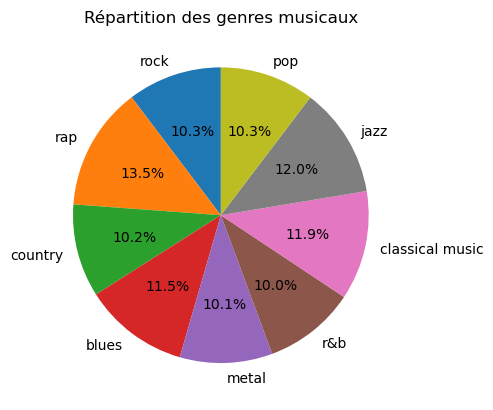

In [40]:
Dataset_Genres_bis = Dataset_Genres.copy()

for genre in final_genre_list:
    Dataset_Genres_bis[genre]= Dataset_Genres_bis['genre'].str.contains(genre, case=False).astype(bool).astype(int)
Dataset_Genres_bis.head(5)
genre_repartition = []
for genre in final_genre_list:
    acc = 0
    acc = Dataset_Genres_bis[genre].sum()
    genre_repartition.append(acc)

#représentation graphique des genres

'''
ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal') 
plt.tight_layout()
'''
plt.pie(genre_repartition, labels=final_genre_list, autopct='%1.1f%%', startangle=90)
plt.title('Répartition des genres musicaux')
plt.show()

2. __Lien entre les variables et les genres__

Ensuite, nous chercher à comprendre les liens entre nos variables et entre nos genres. Pour cela, nous traçons la matrice de corrélation de notre base de données numériques.

Text(0.5, 1.0, 'Matrice de corrélation')

<Figure size 640x480 with 0 Axes>

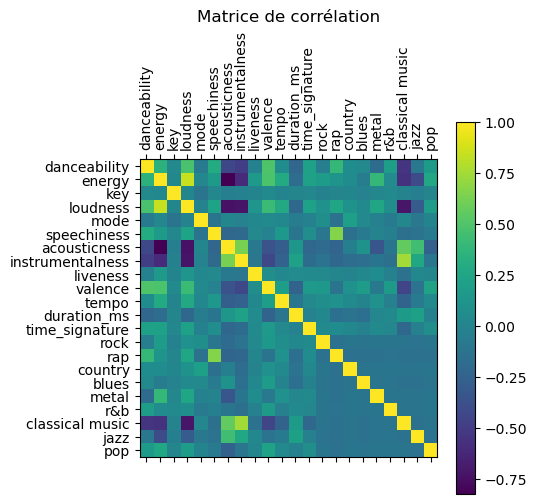

In [41]:
#matrice correlation avec les genres

Dataset_Genres_bis = Dataset_Genres_bis.drop(columns='genre')
f = plt.figure()

plt.matshow(Dataset_Genres_bis.corr())
plt.xticks(range(Dataset_Genres_bis.shape[1]), Dataset_Genres_bis.columns, rotation=90, fontsize= 10)
plt.yticks(range(Dataset_Genres_bis.shape[1]), Dataset_Genres_bis.columns, fontsize=10)

cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Matrice de corrélation')


On peut tirer de cette visualisation différentes observations.

D'abord, on remarque que energy est fortement correlée à loudness (positivement), acousticness et instrumentalness (négativement).
Ainsi, plus la musique bruyante, forte, plus elle est énergique. On pouvait s'y attendre. Plus la musique est instrumentale et acoustique, moins elle est énergique. On peut donc penser que l'énergie de la musique provient principalement de la présence d'un chanteur et d'instruments électriques.
Comme ces quatres variables sont correlées, nous pourrions en éluder pour gagner du temps lors des modélisations de machine learning.

Ensuite, on peut voir que le rap est le seul genre musical corrélé à speechiness (positivement). En effet, le rap est né de la volonté des chanteurs de dénoncer par les paroles, et aujourd'hui les rappeurs tentent de sortir du lot par leurs phrasés. Ainsi, il est logique que ce genre musical soit corrélé à speechiness. De plus, le fait que c'est le seul genre corrélé à cette variable nous laisse penser que ce genre musical sera bien reconnu par nos modèles de machine learning.

Nous observons également que classical music est fortement corrélé à instrumentalness (positivement). De plus, ce genre musical est aussi fortement corrélé à loudness (négativement). Ces résultats étaient attendus puisque la musique classique est un genre où la musique n'est jouée que par des instruments, sans chanteur, et où l'harmonie créée n'est généralement pas bruyante. Ce genre est le seul ayant ces propriétés fortes, à l'exception du jazz qui peut s'en rapprocher comme on le voit. Ainsi, nous pouvons attendre de nos modèles de machine learning une bonne détection de classical music, avec peut-être quelques errerus avec le jazz.

Enfin, les genres rock, r&b, pop, country et blues ne présentent pas de propriétés determinantes à vue d'oeil : nous anticipons donc que ces genres la serons sûrement moins identifiés.

3. __Graphes divers__



Camembert de la répartition des genres.

Pour chaque genre ; sortir Espérance, Variance ? dans histogramme

Pour chaque genre : faire une matrice des corrélations du dataset restreint au genre en particulier ?

Pour chaque genre : faire un graphe de telle variable en fonction de telle autre ?

In [42]:
y_acousticness = []
y_danceability = []
y_energy = []
y_instrumentalness = []
y_liveness = []
y_loudness = []
y_speechiness = []
y_tempo = []
y_valence = []

for genre in final_genre_list:
    Dataset_genre = Dataset_Genres.groupby(Dataset_Genres[genre])
    y_acousticness.append(Dataset_genre['acousticness'].mean()[1])
    y_danceability.append(Dataset_genre['danceability'].mean()[1])
    y_energy.append(Dataset_genre['energy'].mean()[1])
    y_instrumentalness.append(Dataset_genre['instrumentalness'].mean()[1])
    y_liveness.append(Dataset_genre['liveness'].mean()[1])
    y_loudness.append(Dataset_genre['loudness'].mean()[1])
    y_speechiness.append(Dataset_genre['speechiness'].mean()[1])
    y_tempo.append(Dataset_genre['tempo'].mean()[1])
    y_valence.append(Dataset_genre['valence'].mean()[1])

x = np.arange(len(final_genre_list))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width, y_acousticness, width, label='acousticness moyen', color='red', edgecolor = "black")
rects2 = ax.bar(x - 3*width/4, y_danceability, width, label='danceability moyen', color='blue', edgecolor = "black")
rects3 = ax.bar(x - width/2, y_energy, width, label='energy moyen', color='green', edgecolor = "black")
rects4 = ax.bar(x - width/4, y_instrumentalness, width, label='instrumentalness moyen', color='yellow', edgecolor = "black")
rects5 = ax.bar(x , y_liveness, width, label='liveness moyen', color='pink', edgecolor = "black")
rects6 = ax.bar(x + width/4, y_loudness, width, label='loudness moyen', color='purple', edgecolor = "black")
rects7 = ax.bar(x + width/2, y_speechiness, width, label='speechiness moyen', color='orange', edgecolor = "black")
rects8 = ax.bar(x + 3*width/4, y_tempo, width, label='tempo moyen', color='brown', edgecolor = "black")
rects9 = ax.bar(x + width, y_valence, width, label='valence moyen', color='grey', edgecolor = "black")
plt.grid(linestyle = "dashed", alpha = 0.5, color = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Caractéristiques moyennes par genre', fontsize= 20)
ax.set_xticks(x)
ax.set_xticklabels(final_genre_list, fontsize=16,  rotation=45)
ax.legend()

fig.tight_layout()

plt.show()

KeyError: 'rock'

# __III. Modélisation__

Enfin, nous allons utiliser des modèles de machine learning pour prédire le genre d'une musique grâce aux variables dont nous disposons. Nous utilisons d'abord un modèle de type Random Forest, puis un modèle de type XGBoost, pour finalement comparer les deux.

Nous avons réalisé cette partie à partir du site https://larevueia.fr/machine-learning-pour-la-classification-automatique-de-musiques-avec-python/.

 1. __Random Forest__


Tout d'abord, nous séparons la variable à prédire (le genre) des autres variables (les features). Ensuite, nous séparons ces ensembles en deux parties, l'une pour entraîner le modèle et l'autre pour tester le modèle. Comme notre base de données est ordonnée par genre, nous indiquons qu'il faut bisséquer aléatoirement cette base de données avec l'argument shuffle=True.

In [ ]:
features = Dataset_Genres.copy()

# isolation of the feature to predict
genres = np.array(features['genre'])
features = features.drop('genre', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# separation in training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

# reshaping
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)


Maintentant, nous allons procéder au tuning des hyper-paramètres.

In [ ]:
rf = RandomForestClassifier(random_state = 0)

print('Parameters currently in use:\n')
pprint(rf.get_params())

Il y a bien trop d'hyper-paramètres sur lesquels nous pouvons jouer. Nous choisissonsde jouer sur le nombre d'arbres, la profondeur maximale des arbres, le nombre minimal d'échantillons par noeuds, et le nombre minimal d'échantillons par feuilles.

Nous n'avons pas indiqué des poids pour chaque genre, car la base de données est relativement équilibrée. Pour améliorer le modèle, nous pourrions mettre des poids à chaque genre pour avoir une base de données parfaitement équilibrée.

Voici, les valeurs pour lesquelles nous allons tester les performances du modèle.

In [ ]:
n_estimators = [500, 1000, 2000, 3000, 4000, 5000]
max_depth = [20,None]
min_samples_split = [2, 4]
min_samples_leaf = [1, 2]

# creation of the grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }

pprint(random_grid)

Nous faisons donc un random search avec ces différents hyper-paramètres et nous classons les différentes combinaisons d'hyper-paramètres par précision.

Nous voyons que les résultats sont meilleurs lorsqu'on fixe min_samples_split à 4 et min_samples_leaf à 1. De plus, nous observons de meilleurs résultats pour 2000 et 4000 arbres.

In [ ]:
# creation of the model
rf = RandomForestClassifier(random_state = 0, max_features = 'sqrt', bootstrap = True)

# random search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# fit
rf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(rf_random.cv_results_["params"]),pd.DataFrame(rf_random.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(rf_random.best_params_)
print(pd_res)

Après ces premiers résultats, nous fixons donc min_samples_split à 4 et min_samples_leaf à 1, et nous continuons notre sélection d'hyper-paramètres (nombre d'arbres et profondeur maximale d'un arbre) grâce à un grid search.

De même, nous classons les résultats obtenus par précision.

Nous fixons alors le nombre d'arbres à 4000, et nous choisissons de garder une profondeur maximale à 20 car il est risqué de fixer une trop grande profondeur (possible overfitting).

In [ ]:
param_grid = {
    'max_depth': [20, None],
    'min_samples_split': [4],
    'n_estimators': [2000, 4000]
}
pprint(param_grid)

# création du modèle
rf = RandomForestClassifier(random_state = 0, bootstrap=True)

# grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

Nous avons donc fini la partie du tuning des hyper-paramètres, et nous pouvons alors lancer le modèle.

In [ ]:
# creation of the model
rf = RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=4, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

# fit
rf.fit(train_features, train_genres)

# prédictions
predictions = rf.predict(test_features)

# Zero_one_loss error
errors = zero_one_loss(test_genres, predictions, normalize=True)
print('zero_one_loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, test_genres))

Nous obtenons une précision de 68% ce qui est satisfaisant !

DISCUTER RESULTAT PAR GENRE

Nous traçons la matrice de confusion pour visualiser les différentes erreurs.

In [ ]:
#Confusion matrix

mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
#plt.colorbar(label='Valeurs')
plt.title('Matrice de Confusion')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)

plt.xticks(np.arange(num_cols), final_genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), final_genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

FINIR ICI

In [ ]:
#Feature importances
plt.style.use('fivethirtyeight')

importances = list(rf.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

Enfin, nous FINIR ICI

2. __XGBoost__

In [ ]:
features = Dataset_Genres.copy()

def genre_to_num(genre):
    if genre == 'rock':
        return 8
    if genre == 'rap':
        return 7
    if genre == 'r&b':
        return 6
    if genre == 'pop':
        return 5
    if genre == 'metal':
        return 4
    if genre == 'jazz':
        return 3
    if genre == 'country':
        return 2
    if genre == 'classical music':
        return 1
    if genre == 'blues':
        return 0
features['genre'] = features['genre'].apply(genre_to_num)

# isolation of the feature to predict
genres = np.array(features['genre'])
features = features.drop('genre', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# separation in training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

In [ ]:
clf = XGBClassifier(objective= 'multi:softprob', random_state = 42)
print('Parameters currently in use:\n')
pprint(clf.get_params())

In [ ]:
random_grid = {
    "colsample_bylevel" : [1],
    "colsample_bytree" : [1],
    "gamma" : [0],
    "max_delta_step" : [0],
    "min_child_weight" : [1],
    "learning_rate" : [0.1],
    "max_depth" : [20, None],
    "n_estimators" : [100, 200, 300, 400, 500], 
    "subsample" : [0.8]}

pprint(random_grid)

In [ ]:
# création du modèle
clf = XGBClassifier(objective= 'multi:softprob', random_state=42)

# random search
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# fit le modèle
clf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(clf_random.cv_results_["params"]),pd.DataFrame(clf_random.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

In [ ]:
param_grid = {
    "learning_rate" : [0.1], #d0.3
    "max_depth"        : [20], #d6
    "n_estimators" : [300, 350, 450], #d100
    "subsample" : [0.8], #d1
}

pprint(param_grid)

In [ ]:
clf = XGBClassifier(objective= 'multi:softprob', random_state = 0)

grid = GridSearchCV(clf, param_grid = param_grid, n_jobs=-1, scoring="accuracy", cv=3) #scoring="neg_log_loss"
grid.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

In [ ]:
# model
model_xgb = XGBClassifier(objective='multi:softprob', colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=20, min_child_weight=1, n_estimators=300, subsample=0.8, random_state = 42)

# fit the model with the training data
model_xgb.fit(train_features, train_genres)

# predict the target on the test dataset
predict_test = model_xgb.predict(test_features)
 
# Accuracy Score on test dataset
accuracy_test = accuracy_score(test_genres, predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)
print(classification_report(predict_test, test_genres))

In [ ]:
#Matrice de confusion
mat = confusion_matrix(test_genres, predict_test)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
#plt.colorbar(label='Valeurs')
plt.title('Matrice de Confusion')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['blues','classical music','country','jazz','metal','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

3. __Résultats__